In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal,fft
from phylib.io.traces import get_ephys_reader
import glob
from pathlib import Path
from typing import List, Dict, Tuple
from ephysvibe.structures.trials_data import TrialsData

#### Define functions

In [2]:
def filter_continuous(x):
    """Basic filtering of the continuous LFP before cutting it into epochs.
    The signal is expected to be already low-pass filtered at 250Hz
    """
    fs_lfp = 30000  # sampling frequency of the signal in Hz
    fc_hp = 250  # cut-off frequency of the high pass filter in Hz

    # perform a High pass filter - butterworth filter of order 6 at 1Hz
    sos = signal.butter(6, fc_hp, "hp", fs=fs_lfp, output="sos")
    x_hp = signal.sosfilt(sos, x)

    return x_hp

In [3]:
def load_continuous_dat(obj, **kwargs):
    """load continuous.dat.
    Parameters
    ----------
    obj : str or Path
        Path to the raw data file.
    sample_rate : float
        The data sampling rate, in Hz.
    n_channels_dat : int
        The number of columns in the raw data file.
    dtype : str
        The NumPy data type of the raw binary file.
    offset : int
        The header offset in bytes.
    """
    kwargs = {
        k: v for k, v in kwargs.items()
        if k in ('sample_rate', 'n_channels_dat', 'dtype', 'offset')}
    traces = get_ephys_reader(obj, **kwargs)
    
    return  traces

In [4]:
def load_event_files(event_path: Path) -> Dict:
    """Load files in the event folder from OE.

    Args:
        event_path (Path): path to the events folder

    Returns:
        Dict[np.ndarray, np.ndarray, np.ndarray]:
            - samples (np.ndarray): n sample at wich each event acurres
            - channel (np.ndarray): channel that change of state at each sample
            - state (np.ndarray): state of the channel:
                - 1 switched to on
                - 0 switched to off
    """
    samples = np.load(glob.glob("/".join([event_path] + ["sample_numbers.npy"]))[0])
    channel = np.load(glob.glob("/".join([event_path] + ["states.npy"]))[0])
    state = np.where(channel > 0, 1, 0)
    channel = abs(channel)
    events = {"samples": samples, "channel": channel, "state": state}
    return events

In [5]:

def reconstruct_8bits_words(
    real_strobes: np.ndarray, e_channel: np.ndarray, e_state: np.ndarray
) -> np.ndarray:
    idx_old = 0
    current_8code = np.zeros(8, dtype=np.int64)
    full_word = np.zeros(len(real_strobes))

    for n_strobe, idx_strobe in enumerate(real_strobes):

        for ch in np.arange(0, 7):

            idx_ch = np.where(e_channel[idx_old:idx_strobe] == ch + 1)[0]

            current_8code[7 - ch] = (
                e_state[idx_ch[-1]] if idx_ch.size != 0 else current_8code[7 - ch]
            )

        full_word[n_strobe] = int("".join([str(item) for item in current_8code]), 2)

    return full_word

In [6]:
def find_events_codes(
    events
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Reconstruct 8 bit words
    
    idx_real_strobes = np.where(
        np.logical_and(
            np.logical_and(events["channel"] == 8, events["state"] == 1),
            events["samples"] > 0,
        )
    )[
        0
    ]  # state 1: ON, state 0: OFF
    full_word = reconstruct_8bits_words(
        idx_real_strobes, e_channel=events["channel"], e_state=events["state"]
    )
    # Check if strobe and codes number match
    #full_word, idx_real_strobes, bhv = check_strobes(bhv, full_word, idx_real_strobes)
    real_strobes = events["samples"][idx_real_strobes]
    # ! check if time == in oe and ML
    start_trials = real_strobes[full_word == 9]
    end_trials = real_strobes[full_word == 18]
    return (full_word, real_strobes, start_trials, end_trials)

#### Load data

In [7]:
path = '/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-02-27_10-50-03/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/'
continuous_path = '/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-02-27_10-50-03/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
event_path = "/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-02-27_10-50-03/Record Node 102/experiment1/recording1/events/Acquisition_Board-100.Rhythm Data/TTL"

In [8]:
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-02-27_10-50-03_Riesling_lip_e1_r1.h5"
#s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

In [8]:
#events = load_event_files(event_path)
c_samples = np.load('/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-02-27_10-50-03/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/sample_numbers.npy')
shape_0 = len(c_samples)
shape_1=163
sample_rate=30000
print(shape_0,shape_1)

137678592 163


In [9]:
args={'sample_rate':sample_rate,'n_channels_dat':shape_1,'dtype':"int16"}
cont = load_continuous_dat(continuous_path, **args)

In [8]:
# cont = np.memmap(
#     continuous_path,
#     mode="r",
#     dtype="int16",
#     shape=(shape_0, shape_1),
# ).T

In [11]:
# specify the identity of the template that was used to extract each spike [n spikes]
spike_templates = np.load(path+'spike_templates.npy').reshape(-1)
print("spike_templates [%d]"%spike_templates.shape)
# [nSpikes, nTempFeatures]
template_features = np.load(path+'template_features.npy')
print("template_features [%d,%d]"%template_features.shape)
# cluster identity of each spike [nSpikes]
spike_clusters = np.load(path+'spike_clusters.npy')
print("spike_clusters [%d]"%spike_clusters.shape)
# 
spike_times = np.load(path+'spike_times.npy')
amplitudes = np.load(path+'amplitudes.npy')
# [nTemplates, nTimePoints, nTemplateChannels]
templates = np.load(path+'templates.npy')
print("templates [%d,%d,%d]"%templates.shape)
# [nTemplates, nTempChannels]
templates_ind = np.load(path+'templates_ind.npy')
print("templates_ind [%d,%d]"%templates_ind.shape)
cluster_info = pd.read_csv(
        path + "cluster_info.tsv", sep="\t"
    ) 
print("cluster_info [%d,%d]"%cluster_info.shape)

spike_templates [455435]
template_features [455435,32]
spike_clusters [455435]
templates [19,82,32]
templates_ind [19,32]
cluster_info [20,11]


#### Explore

In [12]:
# select one cluster
i_cluster = 0
id_cluster = cluster_info['cluster_id'][cluster_info['group']=='good'].values[i_cluster]
i_ch = cluster_info['ch'][cluster_info['group']=='good'].values[i_cluster]
print(id_cluster,i_ch)

6 12


In [13]:
# index of spikes done by the selected cluster
cluster_idx = np.where(spike_clusters==id_cluster)[0]

In [155]:
# identity of the template that was used for each spike
i_sp = 0
template_identity = spike_templates[cluster_idx]
#plt.plot(template_identity)
print(template_identity[i_sp])

6


In [156]:
# timestamp of each spike of the selected cluster
idx_sp_cluster = spike_times[cluster_idx].reshape(-1)

In [157]:
# feature of each template used for each spike in this cluster
cluster_temp_feat = template_features[cluster_idx]
#plt.plot(cluster_temp_feat[i_sp].T)

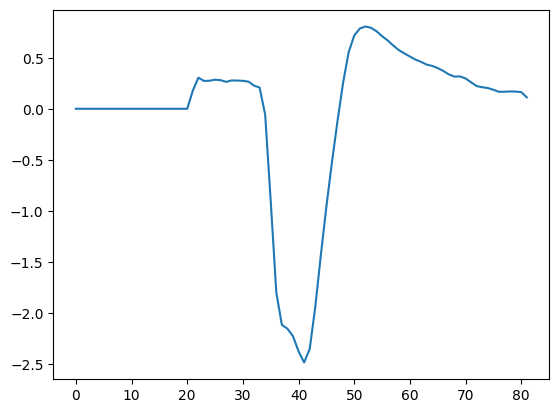

In [158]:
plt.plot(templates[template_identity[i_sp],:,i_ch]*amplitudes.reshape(-1)[cluster_idx][i_sp])

In [43]:
n_trial = 200
data.start_trials[n_trial]


2152211

In [44]:

idx_fix = np.where(data.code_numbers[n_trial]==8)[0]
t_start = int(data.code_samples[n_trial][idx_fix][0])

In [45]:
t_start

1363

In [159]:
start = sample_rate*0
selected_cont = cont[start:sample_rate*2,i_ch].T
cont_hp=filter_continuous(selected_cont)#[int(spike_times[cluster_idx][i_sp]):int(spike_times[cluster_idx][i_sp]+100)]

In [160]:
cont_hp.shape

(60000,)

ValueError: x and y must have same first dimension, but have shapes (3540,) and (0,)

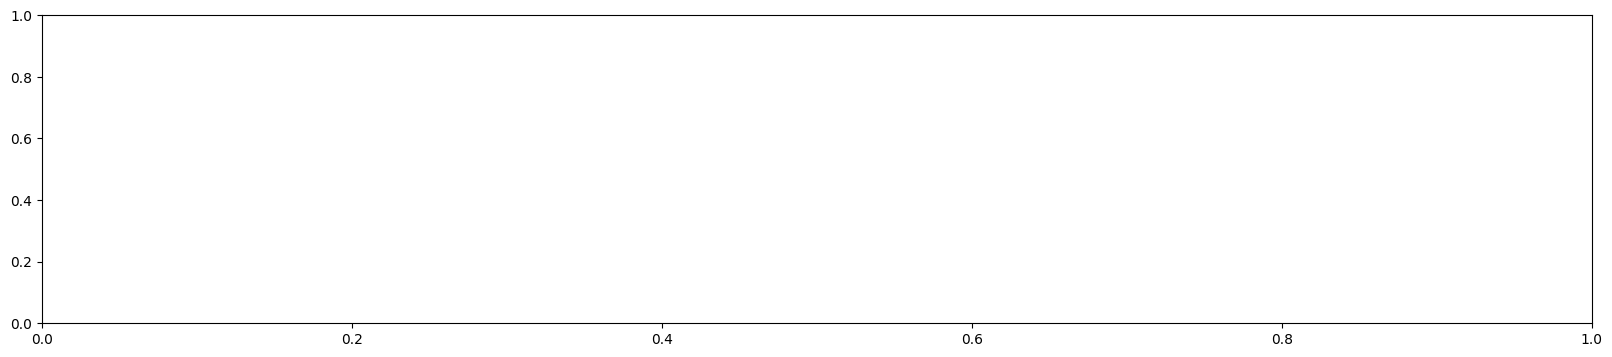

In [161]:
fig,ax = plt.subplots(figsize=(20,4))
i_sp=0
sp_t = int(spike_times[cluster_idx][i_sp])-start
ax.plot(np.arange(sp_t-40,sp_t+3500)/30000,cont_hp[sp_t-40:int(sp_t+3500)])
ax.plot(np.arange(sp_t-40,sp_t+82-40)/30000,templates[template_identity[i_sp],:,i_ch]*amplitudes.reshape(-1)[cluster_idx][i_sp]*100,':')
# i_sp=101
# sp_t = int(spike_times[cluster_idx][i_sp])
# ax.plot(np.arange(sp_t-40,sp_t+82-40)/30000,templates[template_identity[i_sp],:,i_ch]*amplitudes.reshape(-1)[cluster_idx][i_sp]*100,':')
# i_sp=102
# sp_t = int(spike_times[cluster_idx][i_sp])
# ax.plot(np.arange(sp_t-40,sp_t+82-40)/30000,templates[template_identity[i_sp],:,i_ch]*amplitudes.reshape(-1)[cluster_idx][i_sp]*100,':')
# i_sp=103
# sp_t = int(spike_times[cluster_idx][i_sp])
# ax.plot(np.arange(sp_t-40,sp_t+82-40)/30000,templates[template_identity[i_sp],:,i_ch]*amplitudes.reshape(-1)[cluster_idx][i_sp]*100,':')

#### select all spikes of one cluster

In [162]:
import plotly.express as px
from dash import Dash, Input, Output,html,dcc
# import dash_core_components as dcc
# import dash_html_components as html

In [163]:
step = 500000
steps = np.arange(step,shape_0,step)
last_step = steps[-1]
if last_step < shape_0:
    diff = shape_0-last_step
    if diff < step/2:
        steps[-1] = shape_0
    else:
        steps = np.concatenate(steps,[shape_0])

In [164]:
n_points = 82
prev_i_t = 0
prev_n_sp = 0
clust_spike_times = spike_times[cluster_idx].reshape(-1)
all_sp = []
ch_cont = []
for i_t in steps:
    selected_cont = cont[prev_i_t:i_t,i_ch].T
    cont_hp=filter_continuous(selected_cont)
    # n_sp = np.where((clust_spike_times<i_t-n_points) & (clust_spike_times>prev_i_t))[0].shape[0]

    # all_sp.append(cont_hp[np.array(np.zeros((n_sp,n_points))+np.arange(-40,n_points-40)+(((clust_spike_times[prev_n_sp:prev_n_sp+n_sp]/100000)-prev_i_t/100000)*100000).reshape(n_sp,1),dtype=int)])
    ch_cont.append(cont_hp)
    prev_i_t = i_t
    #prev_n_sp+=n_sp
# sp_neuron = np.concatenate(all_sp,axis=0)
ch_cont = np.concatenate(ch_cont,axis=0)

KeyboardInterrupt: 

In [57]:
#np.save('sp_neuron_test.npy',sp_neuron)

In [60]:
sp_neuron = np.load('sp_neuron_test.npy')

In [191]:
start_trials

array([ 41689862,  41806087,  41941953, ..., 177957232, 178006997,
       178082190])

In [189]:
start_t_value,end_t_value = 1,2
n_points=82
# if end_t_value-start_t_value<1:
#     end_t_value=end_t_value+(1-(end_t_value-start_t_value))
start_t_value = round(start_t_value*sample_rate)
end_t_value = round(end_t_value*sample_rate)
cont_hp = filter_continuous(cont[start_t_value:end_t_value,i_ch].T)

idx_n_sp = np.where((clust_spike_times<end_t_value-n_points/2) & (clust_spike_times>start_t_value+n_points/2))[0]
n_sp=len(idx_n_sp)


base_matrix = np.zeros((n_sp,n_points))+np.arange(-40,n_points-40)

all_sp = cont_hp[np.array(base_matrix+(((clust_spike_times[idx_n_sp]/100000)-start_t_value/100000)*100000).reshape(n_sp,1),dtype=int)]

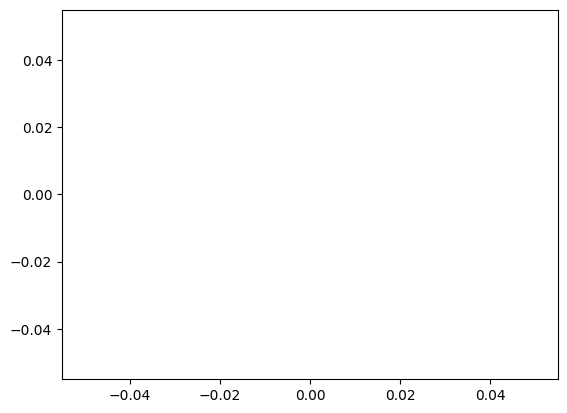

In [190]:
a=plt.plot(all_sp.T)

#### Interactve visualization

In [173]:
start_sp = 0
n_spikes = 50
fig = px.line([0,0,0])

app = Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig,id='fig'),
    html.Div(children=[

        html.Br(),
        html.Label('time interval'),
        dcc.Input(id='start_t', value=0, type='number'),
        dcc.Slider(1, 5, 1, value=1,id='end_t'),


        html.Br(),
        html.Label('Spike n'),
        dcc.Input(id='sp_n', value=0, type='number'),
    ], style={'padding': 10, 'flex': 1}),
    html.Br(),
    html.Div(id='timestamp'),
])


@app.callback(
    Output(component_id='fig', component_property='figure'),
    Input(component_id='start_t', component_property='value'),
    Input(component_id='end_t', component_property='value'),

)
def update_number_spikes(start_t_value,end_t_value):
    n_points=82
    # if end_t_value-start_t_value<1:
    #     end_t_value=end_t_value+(1-(end_t_value-start_t_value))
    end_t_value = start_t_value+end_t_value
    start_t_value = round(start_t_value*sample_rate)
    end_t_value = round(end_t_value*sample_rate)
    cont_hp = filter_continuous(cont[start_t_value:end_t_value,i_ch].T)

    idx_n_sp = np.where((clust_spike_times<end_t_value-n_points) & (clust_spike_times>start_t_value))[0]

    n_sp=len(idx_n_sp)

    base_matrix = np.zeros((n_sp,n_points))+np.arange(-40,n_points-40)

    all_sp = cont_hp[np.array(base_matrix+(((clust_spike_times[idx_n_sp]/100000)-start_t_value/100000)*100000).reshape(n_sp,1),dtype=int)]
    fig = px.line(all_sp.T)

    return fig

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


/home/INT/losada.c/.virtualenvs/spike_view-rAo7T4CO/lib/python3.8/site-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/INT/losada.c/.virtualenvs/spike_view-rAo7T4CO/lib/python3.8/site-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/INT/losada.c/.virtualenvs/spike_view-rAo7T4CO/lib/python3.8/site-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [89]:
base_matrix = np.zeros((n_sp,n_points))+np.arange(-40,n_points-40)

In [92]:
cont_hp=filter_continuous(cont[0:1,i_ch].T)

In [95]:
cont.shape

(137678592, 163)

In [93]:
np.array(base_matrix+(((clust_spike_times[idx_n_sp]/100000)-0/100000)*100000).reshape(n_sp,1),dtype=int)

array([[  157,   158,   159, ...,   236,   237,   238],
       [  679,   680,   681, ...,   758,   759,   760],
       [ 1353,  1354,  1355, ...,  1432,  1433,  1434],
       ...,
       [28968, 28969, 28970, ..., 29047, 29048, 29049],
       [29392, 29393, 29394, ..., 29471, 29472, 29473],
       [29934, 29935, 29936, ..., 30013, 30014, 30015]])

In [38]:
# start_sp = 0
# n_spikes = 50
# fig = px.line(sp_neuron[start_sp:start_sp+n_spikes].T)
# app = Dash()
# app.layout = html.Div([
#     dcc.Graph(figure=fig,id='fig'),
#     html.Div(children=[

#         html.Br(),
#         html.Label('Number of spikes'),
#         dcc.Input(id='sp_to_display', value=50, type='number'),

#         html.Br(),
#         html.Label('Spike n'),
#         dcc.Input(id='sp_n', value=0, type='number'),
#     ], style={'padding': 10, 'flex': 1}),
#     html.Br(),
#     html.Div(id='timestamp'),
# ])


# @app.callback(
#     Output(component_id='fig', component_property='figure'),
#     Output(component_id='timestamp', component_property='children'),
#     Input(component_id='sp_to_display', component_property='value'),
#     Input(component_id='sp_n', component_property='value')
# )
# def update_number_spikes(sp_to_display_value,sp_n_value):
#     n_spikes = sp_to_display_value
#     start_sp = sp_n_value
#     fig = px.line(sp_neuron[start_sp:start_sp+n_spikes].T)
#     timestamp = clust_spike_times[start_sp]
#     return fig, timestamp



# app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


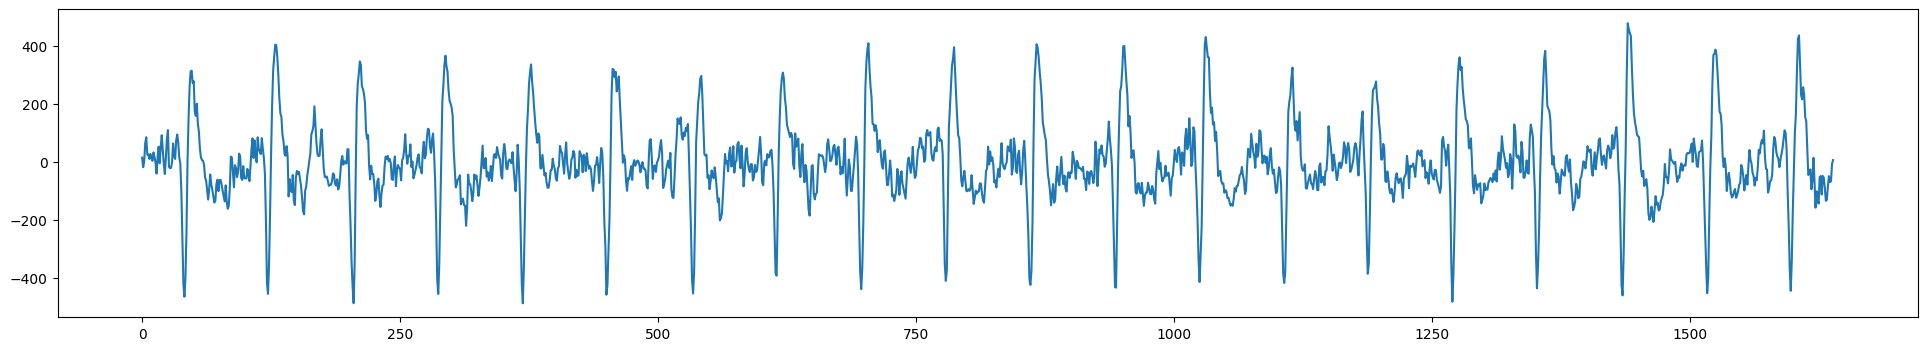

In [ ]:
fig,ax=plt.subplots(figsize=(24,4))
ax.plot(np.concatenate(sp_neuron[0:20]))

In [ ]:
np.percentile(np.max(sp_neuron, axis=1))

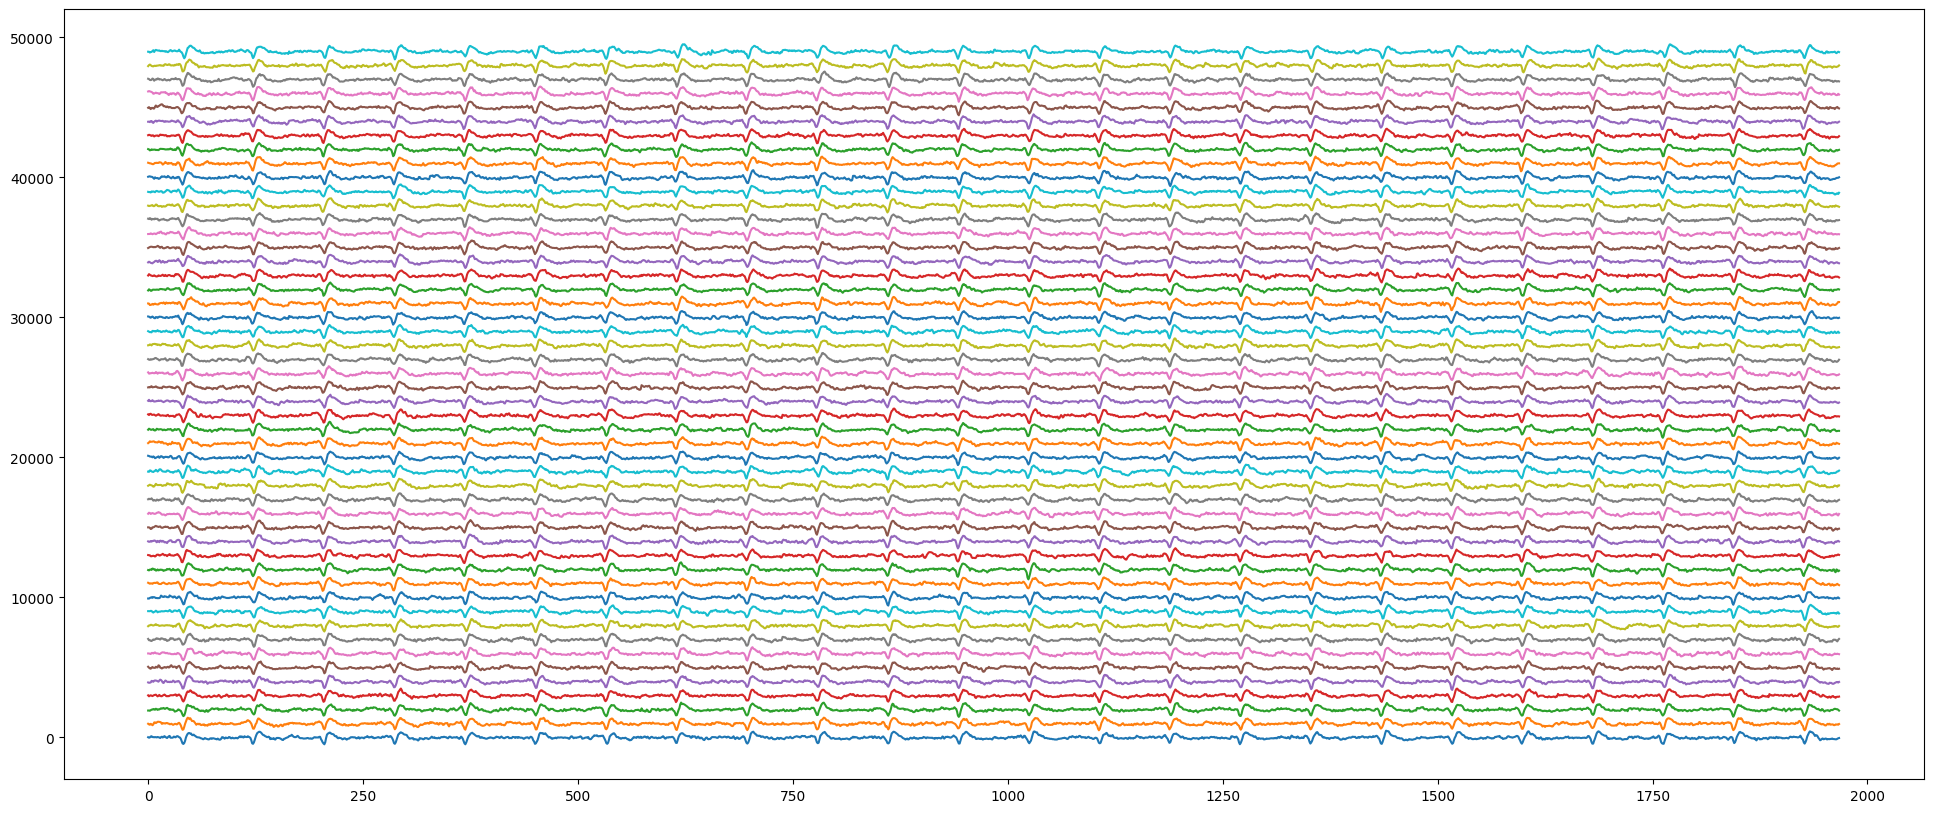

In [ ]:
resto = sp_neuron.shape[0]%24
div = int(np.floor(sp_neuron.shape[0]/24))
fig,ax=plt.subplots(figsize=(24,10))
a=ax.plot((sp_neuron[:-resto].reshape(div,-1)+np.arange(0,2627).reshape(2627,1)*1000)[:50].T)